In [1]:
#tell ipython that we are running in a notebook. 
#this is necessary for the interactive user interface in part 1 below
%matplotlib notebook     

#import a few key modules, these should be sufficient to complete the assignment
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import pickle

#import the provided functions to support point selection in the notebook
import selectpoints


In [2]:
def get_correspondences(imnames,baseim,npoints=4):
    
    """
    The function loads in a set of images which are going to be assembled
    in to a mosaic. It displays the central (base) image along with each
    peripheral image and allows the user to click to to select corresponding
    points between the base image and the peripheral image. It returns the
    images along with the user input. If the original image files were in 
    color the function converts them to grayscale. 
    
    Parameters
    ----------
    imnames : list of str
        Filenames of image files that are going in to the mosaic
    
    baseim : int
        An index which specifies which of the image files is the base image
        
    npoints : int
        How many points are required from the user. Defaults to 4
        
    Returns
    -------
    imgs : list of 2D float arrays
        The arrays for the corresponding images given in imnames. These 
        are gray scale images represented as floats.   
     
    pointmatches : list of SelectPoints objects
        Returns an object whose fields xs and ys contain the point 
        coordinates once the user has clicked  (see selectpoints.py)
        
    """

    nimages = len(imnames)

    #loop over images and load in each one and convert to grayscale
    imgs = list()
    for fname in imnames:  
        print('loading...',fname)
        I = plt.imread(fname)
        
        #convert to float data type if necessary
        if (I.dtype == np.uint8):
            I = I.astype(float)/256
        # downsample the image to 1/4 resolution just to make things run quicker
        I = zoom(I,0.25)
        
        ## your code here
        
        #convert from color to grayscale if necessary
        I = I.mean(axis=2)
        ## your code here
    
        #finally, store the array in our list of images
        imgs.append(I)
 
    #loop over each pair of overlapping images and have the user 
    #click to specify corresponding points
    pointmatches = list()
    for i in range(nimages):
        if (i==baseim):
            continue
        
        fig = plt.figure()
    
        #select points in base image
        ax1 = fig.add_subplot(2,1,1)
        ax1.imshow(imgs[baseim],cmap=plt.cm.gray)
        sp1 = selectpoints.select_k_points(ax1,npoints)

        #corresponding points in overlapping image
        ax2 = fig.add_subplot(2,1,2)
        ax2.imshow(imgs[i],cmap=plt.cm.gray)
        sp2 = selectpoints.select_k_points(ax2,npoints)
 
        pointmatches.append((sp1,sp2))

    return imgs,pointmatches


In [5]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
   
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))


# save everything out to a file so we don't have to click again.
f = open('atrium_correspondeces.pckl','wb')
pickle.dump((baseim,imgs,srcpts,basepts),f)
f.close()

In [3]:
def compute_homography(pts1,pts2):
    """
    Computes the 3x3 transformation matrix (homography) that when applied to pts1 yields pts2
    
    
    Parameters
    ----------
    pts1 : 2xN array
        2D coordinates of points (to warp)

    pts2 : 2xN array
        target 2D coordinates where points should end up

    Returns
    -------
    numpy.array (dtype=float)
        3x3 array containing the matrix H
        
    """

    #expected dimensions of input
    assert(pts1.shape[0]==2)
    assert(pts2.shape[0]==2)
    assert(pts1.shape[1]>=4)
    assert(pts2.shape[1]>=4)
    
    
    
    
    #your code goes here
    #
    changdu =pts1.shape[1]
    
    
    B=np.empty((8,changdu*2))
#     print(B[0])
    for i in range(changdu):
        
        x1=[pts1[0][i],pts1[1][i],1,0,0,0,-pts2[0][i]*pts1[0][i],-pts2[0][i]*pts1[1][i]]
        B[i*2] = np.array(x1)
        y1=[0,0,0,pts1[0][i],pts1[1][i],1,-pts2[1][i]*pts1[0][i],-pts2[1][i]*pts1[1][i]]
        B[i*2+1] = np.array(y1)
    #print(B)


    pts2=np.transpose(pts2)
    C = np.reshape(pts2,(changdu*2,1))
    H = np.linalg.lstsq(B,C,rcond=None)[0]
    
   
     
    H = np.concatenate((H,[[1]]))
    H = H.reshape(3,3)
    assert (H.shape==(3,3))
    return H 





In [4]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates
    
    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform
        
    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points
        
    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)
    
    #your code goes here
    kuan =pts.shape[0]
    changdu =pts.shape[1]
    lastlist=[]
    for i in range(changdu):
        lastlist.append(1)
        
    
    
    
    pts = np.concatenate((pts,[lastlist]))
    
    
    #print(pts)
    a1= np.dot(H,pts)
    
    

    tpts = np.empty((kuan,changdu))    
    tpts[0:2,:] = a1[0:2,:]/a1[2,:]

    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])
    
    return tpts





In [12]:
def warp_images(imgs,baseim,srcpts,basepts):
    """
    Warp a collection of images to align them with a central base image using 
    provided point correspondences to estimate the warping.
    
    
    Parameters
    ----------
    imgs : list of 2D numpy.array (dtype=float)
        The arrays containing the input grayscale images  
  
    baseim : int
        The index of the image which is the central base image
        
    srcpts: list of 2D numpy.array, each of size 2xNclicks 
        x,y coordinates of points clicked by the user for each peripheral image

    basepts : list of 2D numpy.array, each of size 2xNclicks
        x,y coordinates of correponding locations in the base image
        
    Returns
    -------
    imgs_warped: list of 2D numpy.array (dtype=float)
        list of the resulting warped images, all of which will have the same shape
        
    """
    
    # first estimate all the homographies
    homs = list()
    for i in range(len(imgs)):
        #print(i,'img index')
        if (i == baseim):
            H =  np.array([[1,0,0],[0,1,0],[0,0,1]])
        elif(i != baseim) :
            H = compute_homography(srcpts[i-1],basepts[i-1])
           
        homs.append(H)
    
    # compute where the corners of each warped image end up
    # and the upper left and lower-right corners of a rectangle
    # that will enclose all of them
    ul = np.array([0,0])
    lr = np.array([0,0])
    
    
    


    yuankuan =(len(imgs[0]))
    yuanchang =(len(imgs[0][0]))
    
    xminlist =[]
    yminlist =[]
    xmaxlist =[]
    ymaxlist =[]
    
    
    for i in range(len(imgs)):

        
        #print('进入循环  original ')
         
       
        cx = np.array([[0,yuanchang,0,yuanchang],[0,0,yuankuan,yuankuan]])
        
        cx_warped = apply_homography(homs[i],cx)
        
        
        
     
        
        print("zuida zuixiaozhi")
        
        xmin = np.min(cx_warped[0])
        xminlist.append(xmin)
        
        xmax = np.max(cx_warped[0])
        xmaxlist.append(xmax)
        
        
        ymin = np.min(cx_warped[1])
        yminlist.append(ymin)

            
        ymax = np.max(cx_warped[1])
        ymaxlist.append(ymax)

        
    ul[0] = min(xminlist)
    ul[1] = min(yminlist)
    
    lr[0]= max(xmaxlist)
    lr[1]= max(ymaxlist)
    

    
    #round these to integer valued coordinates
    ul = np.floor(ul)
    lr = np.floor(lr)
    print(ul)
    print(lr)    
    
    # generate the coordinates of pixels in the output image that
     # cover the bounding rectangle determined above
  
    ogrid_y, ogrid_x =np.mgrid[ul[1]:lr[1],ul[0]:lr[0]]
    
    
    # loop over each input and warp it
    imgs_warped = list()
    for i in range(len(imgs)):
        
        #input pixel grid
        
        igrid_y,igrid_x = np.mgrid[0:yuankuan,0:yuanchang]
        x1dimension = igrid_x.flatten()
        y1dimension = igrid_y.flatten()
        

        # reshape igrid_y and igrid_x into a 2xN array so we can use
     # our applyHomography function on them. you can do
     # this with some combination of flatten() and stack()
        incoords = np.stack((x1dimension,y1dimension))
 
      
        # transform pixel coordinates
        
        warpedcoords = apply_homography(homs[i],incoords)

        # note: griddata expects coords to be Nx2 and values to be Nx1 so
        # make sure you transpose / flatten as necessary
  
        # brightness values reshaped as a Nx1 array
        bvalues = imgs[i].flatten()
        wcoords = np.transpose(warpedcoords)
        
        # use griddata to warp 
        img_warped = griddata(wcoords,bvalues,(ogrid_x,ogrid_y))
        
        imgs_warped.append(img_warped)
    
    return imgs_warped
           



In [20]:
def blend_images(imgs_warped):
    """
    Blend together a collection of warped images into a mosaic 
    using alpha masks to smooth transitions between individual photos
    
    
    Parameters
    ----------
    imgs_warped : list of 2D numpy.array (dtype=float)
        The arrays containing the warped grayscale images. Assumed to have a value
        of nan value in locations where the brightness is unknown
          
    Returns
    -------
    mosaic: 2D numpy.array (dtype=float)
        The blended mosaic
        
    alphas: list of 2D numpy.array (dtype=float)
        The alpha masks used for blending together the mosaic
        
    """
 
    # compute a mask for each warped image which is 1.0 were the pixels are valid
    # and 0.0 anywhere there is a NaN
    masks = list()
    for i in range(len(imgs_warped)):
        
        mask = np.isnan(imgs_warped[i])
        
        masks.append(mask)
        
    # now compute a alpha map by blurring the masks to feather the boundaries,
    # clipping them to make sure they are zero anywhere the mask is 0, and
    alphas = list()
    for i in range(len(imgs_warped)):
        
        
        alpha = gaussian_filter(imgs_warped[i],0.1)
        
        alpha = np.where(masks[i]==True,0,alpha)
        
        
        alphas.append(alpha)
    
    
        
    # normalized the alphas so that they sum to 1 anywhere they overlap
    # if a pixel is not covered by any input image, then set the alphas to 0.
    print('kong')
    kongsum =np.zeros(alphas[0].shape)
    
    for al in alphas:
        al = np.where(np.isnan(al),0,al)
        kongsum+=al
    
    
    np.seterr(divide='ignore',invalid='ignore')
    kongsum = np.where(np.isnan(kongsum),0,kongsum)
    
    
    #set alpha to 0
    alphas = np.where(kongsum==0,0,alphas/kongsum)
        
    
    #finally blend together all the sorce images using the alpha weights
    # create an output image of all zeros where we will composite the warped images
    mosaic = np.zeros(imgs_warped[0].shape)

    #You will need to modify this code to deal with the fact that imgs_warped 
    #contains NaNs.  Your output mosaic should not contain any NaNs, just 0s
    #in the places which are not covered by any input image
    for i in range(len(imgs_warped)):
        #fixme!
        imgs_warped[i] = np.where(np.isnan(imgs_warped[i]),0,imgs_warped[i])
        mosaic = mosaic + alphas[i]*imgs_warped[i]
    
    
    return mosaic, alphas
              

zuida zuixiaozhi
zuida zuixiaozhi
zuida zuixiaozhi
[-456. -552.]
[1092. 1185.]


<IPython.core.display.Javascript object>


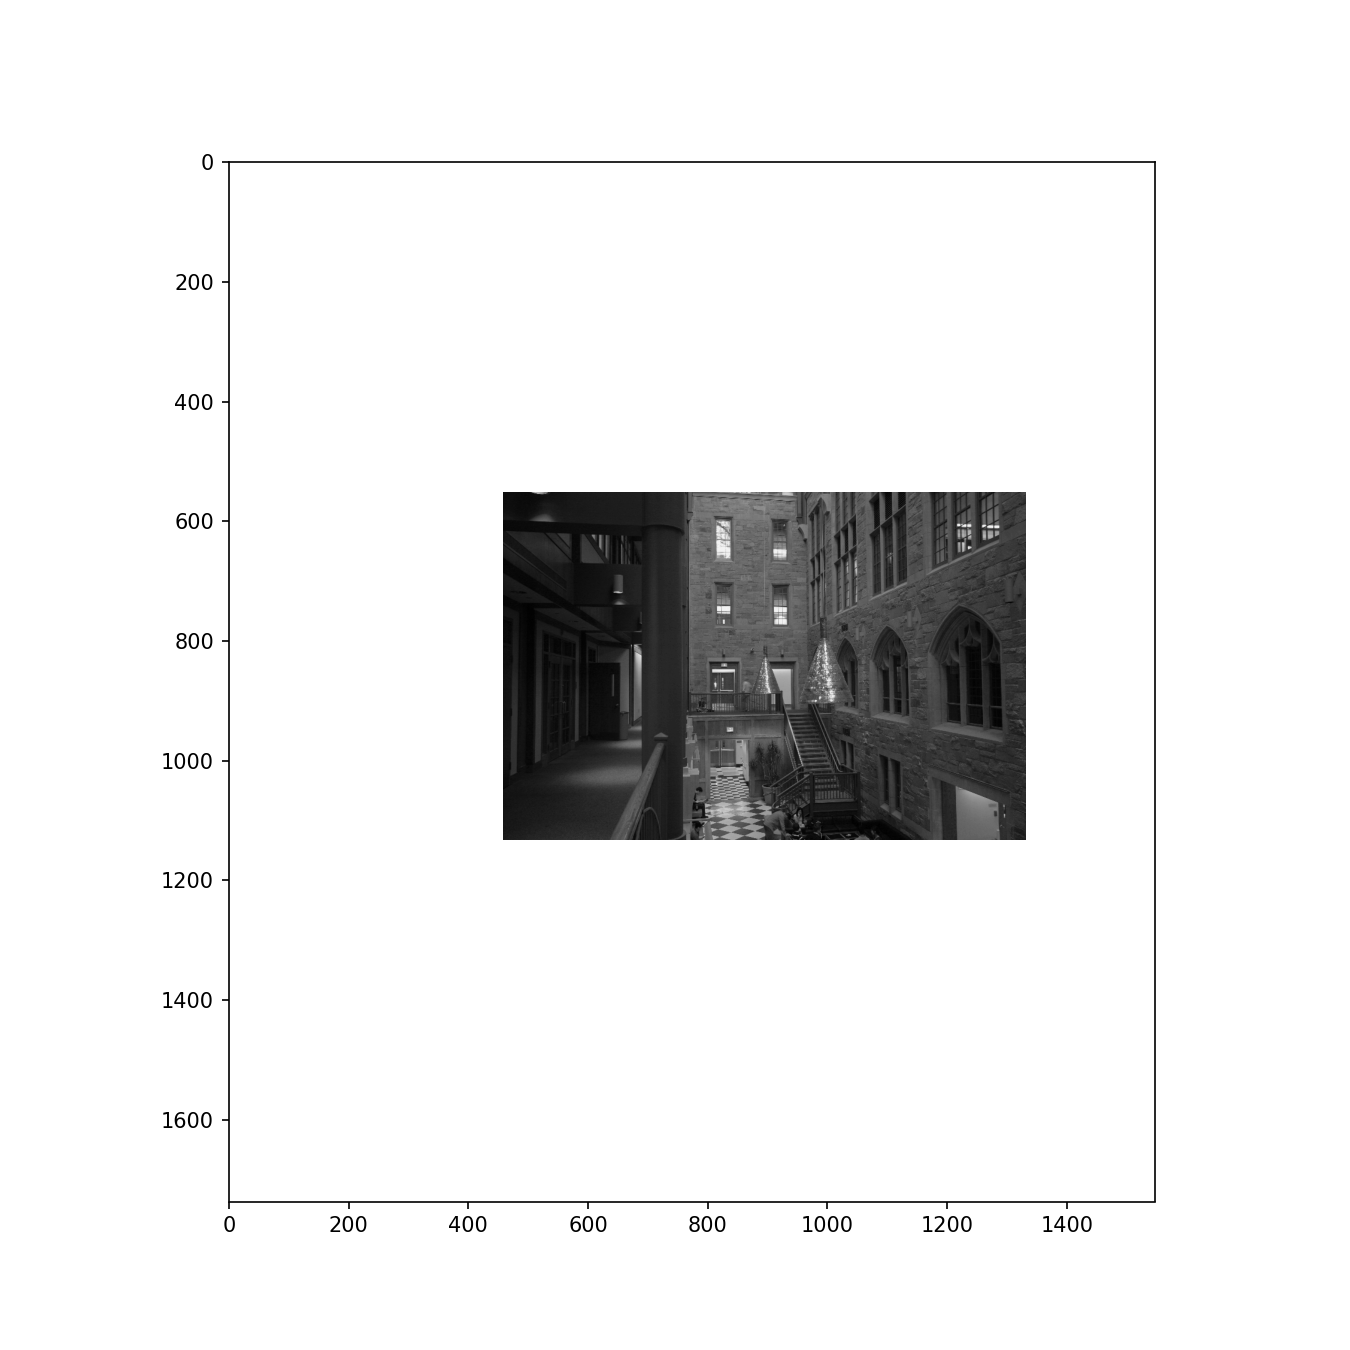

<IPython.core.display.Javascript object>


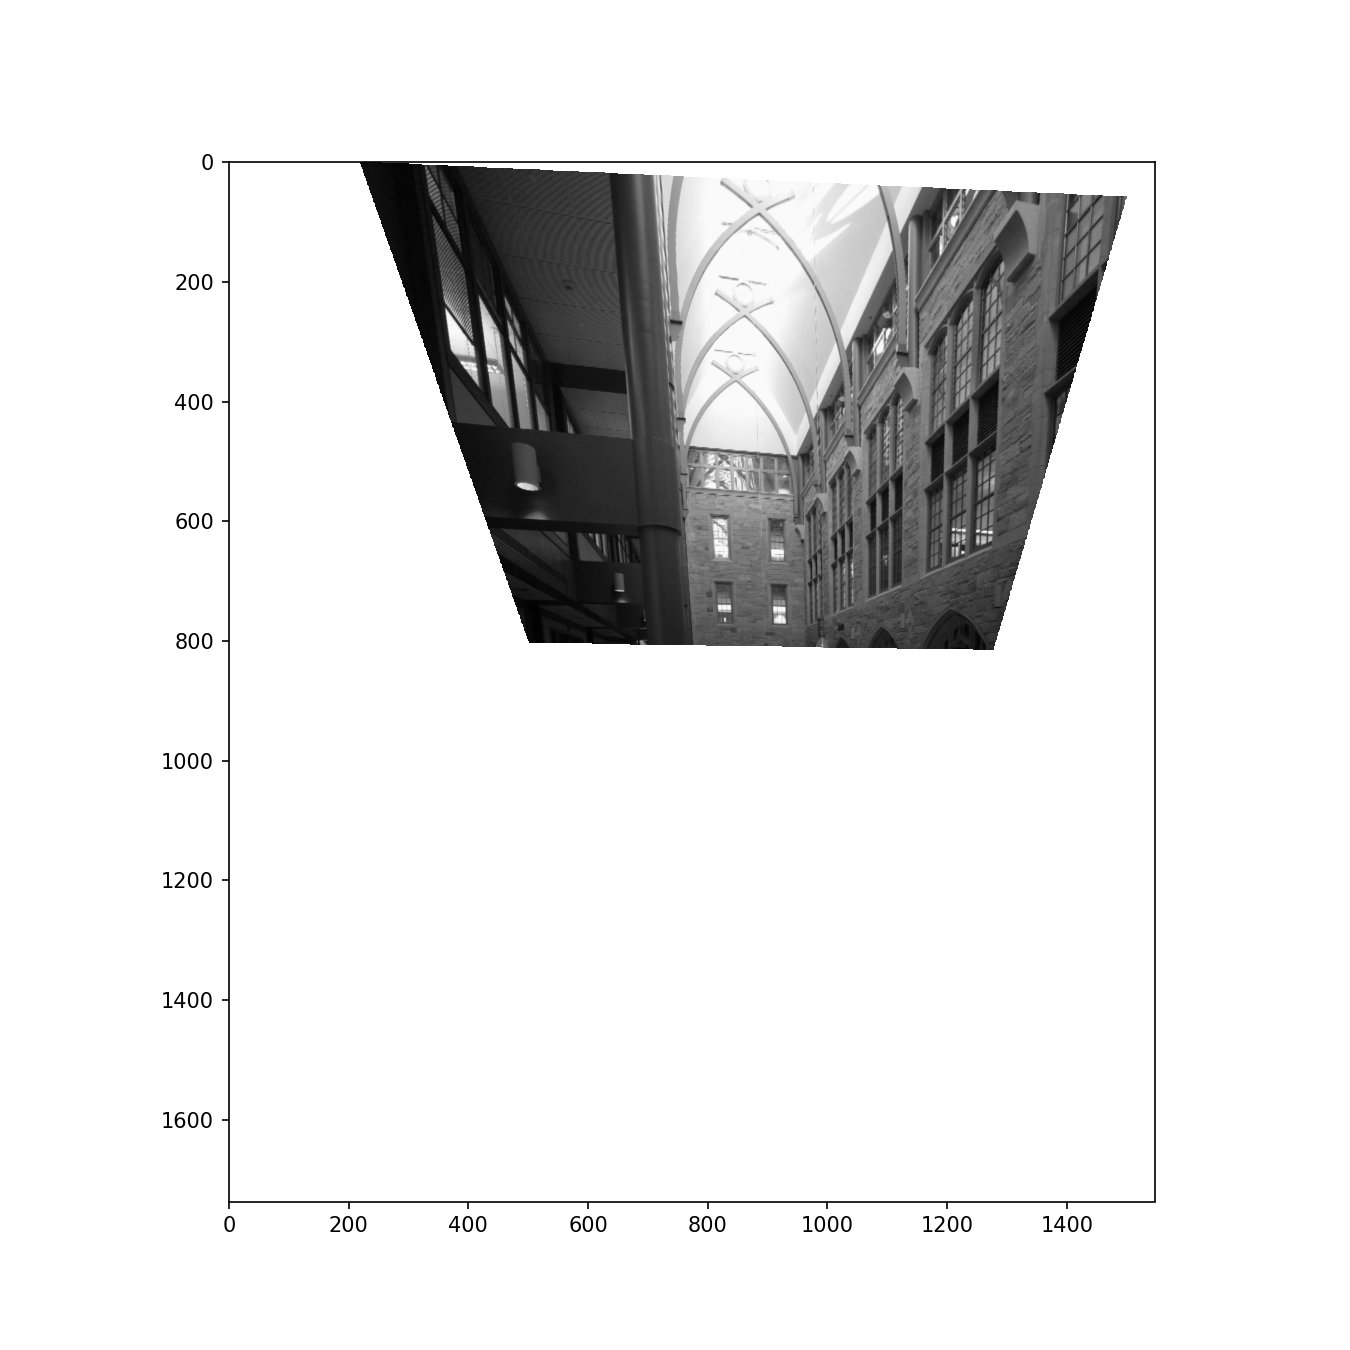

<IPython.core.display.Javascript object>


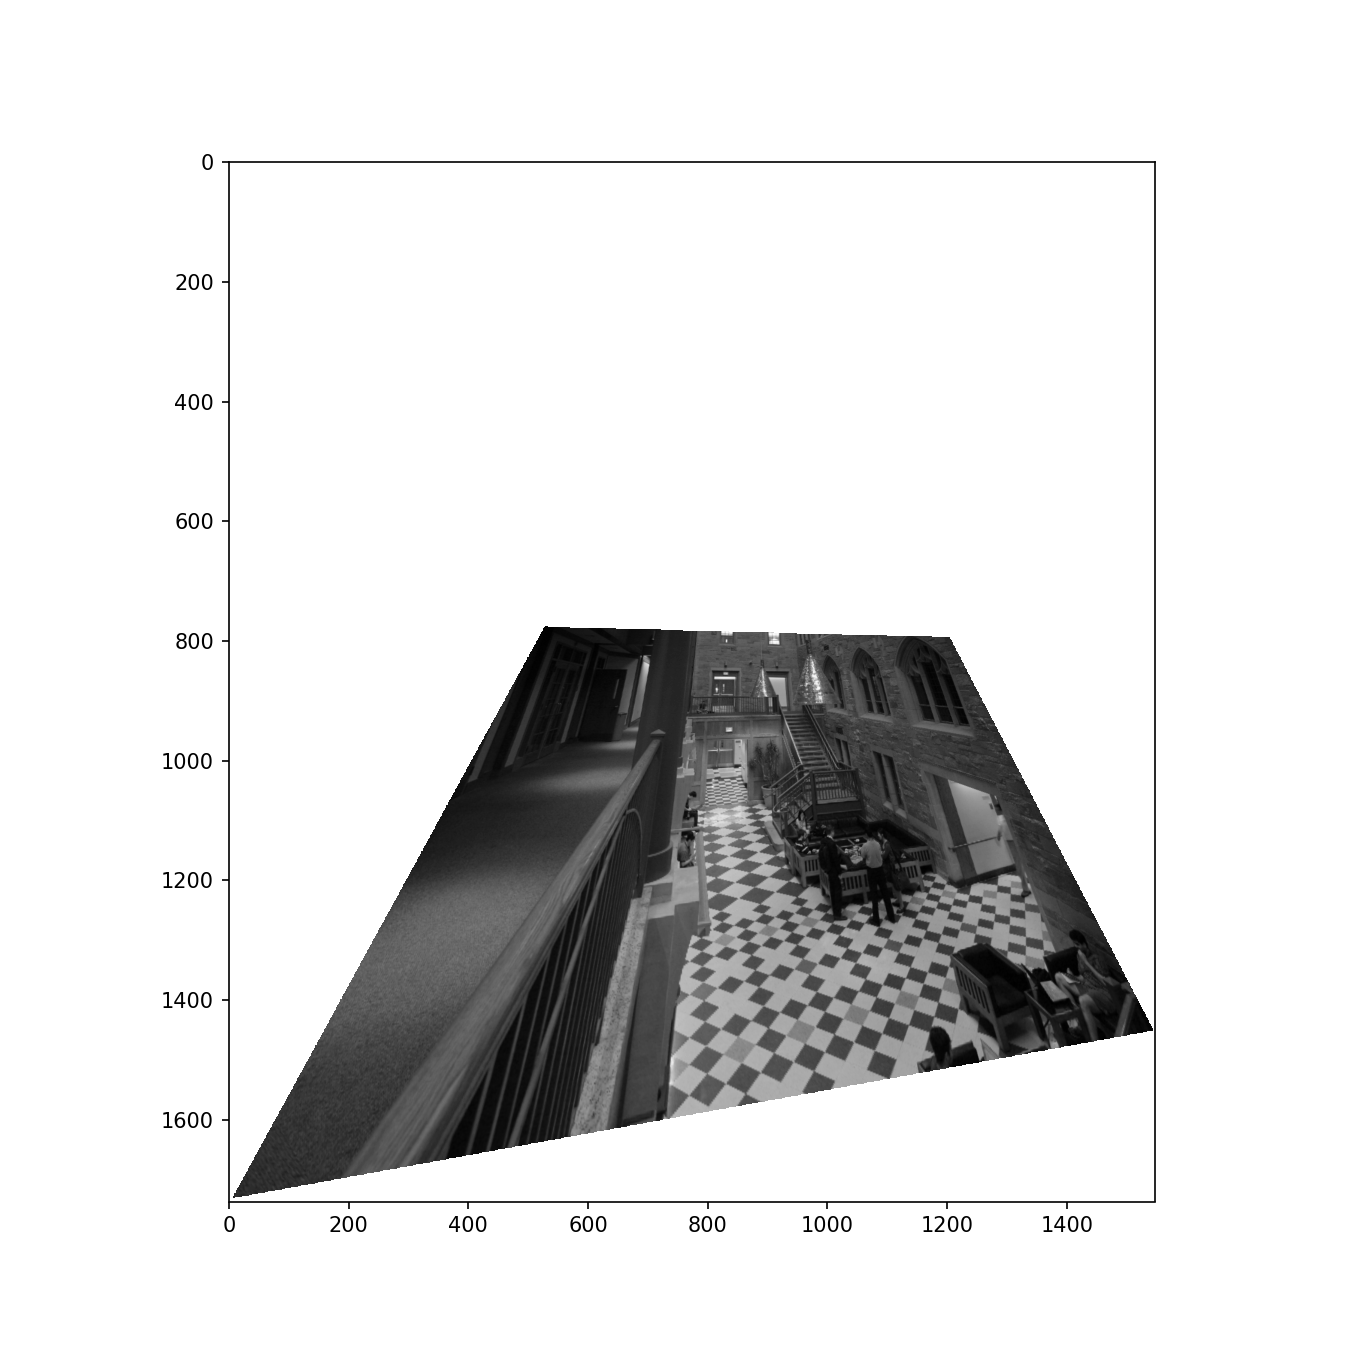

In [17]:
f = open('atrium_correspondeces.pckl','rb')
baseim,imgs,srcpts,basepts = pickle.load(f)
f.close()
#I reuse the points from pckl because I choose same points

imgs_warped = warp_images(imgs,baseim,srcpts,basepts)    

for i in range(len(imgs_warped)):
    fig = plt.figure()
    plt.imshow(imgs_warped[i],cmap=plt.cm.gray)
    plt.show()
# add code here to display imgs_warped, alphas and the final mosaic in the notebook




kong


<IPython.core.display.Javascript object>


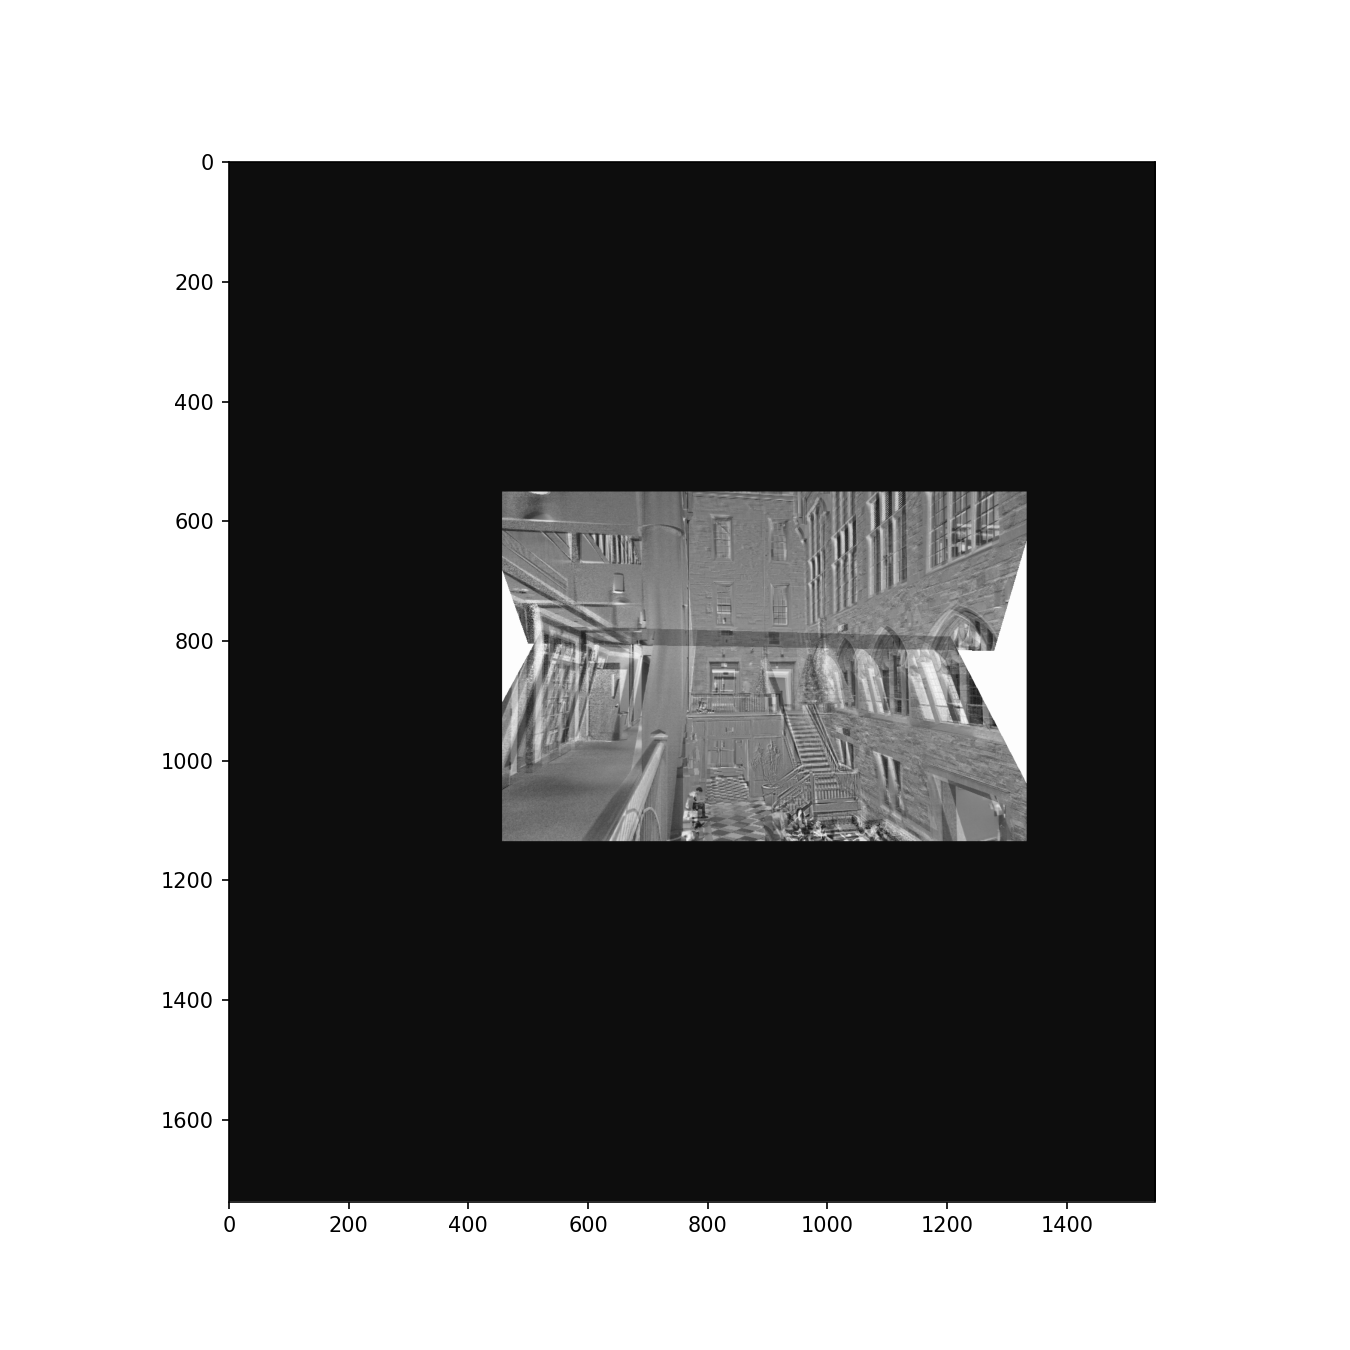

<IPython.core.display.Javascript object>


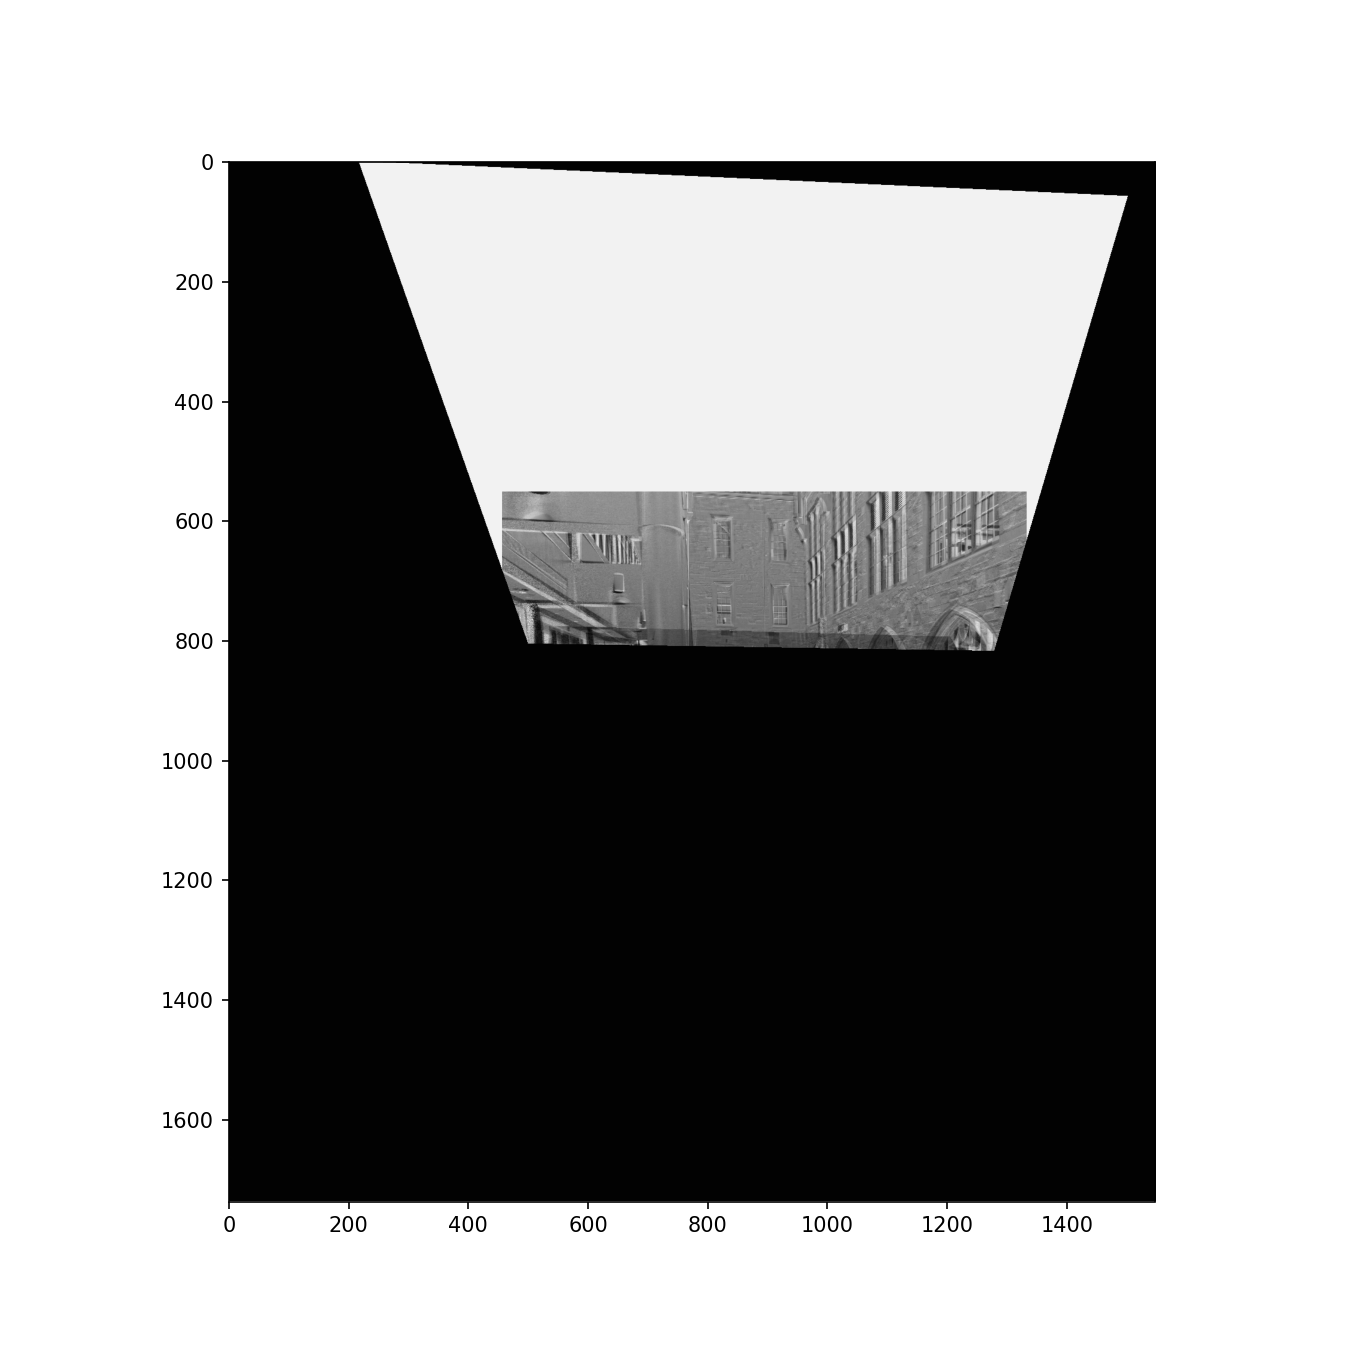

<IPython.core.display.Javascript object>


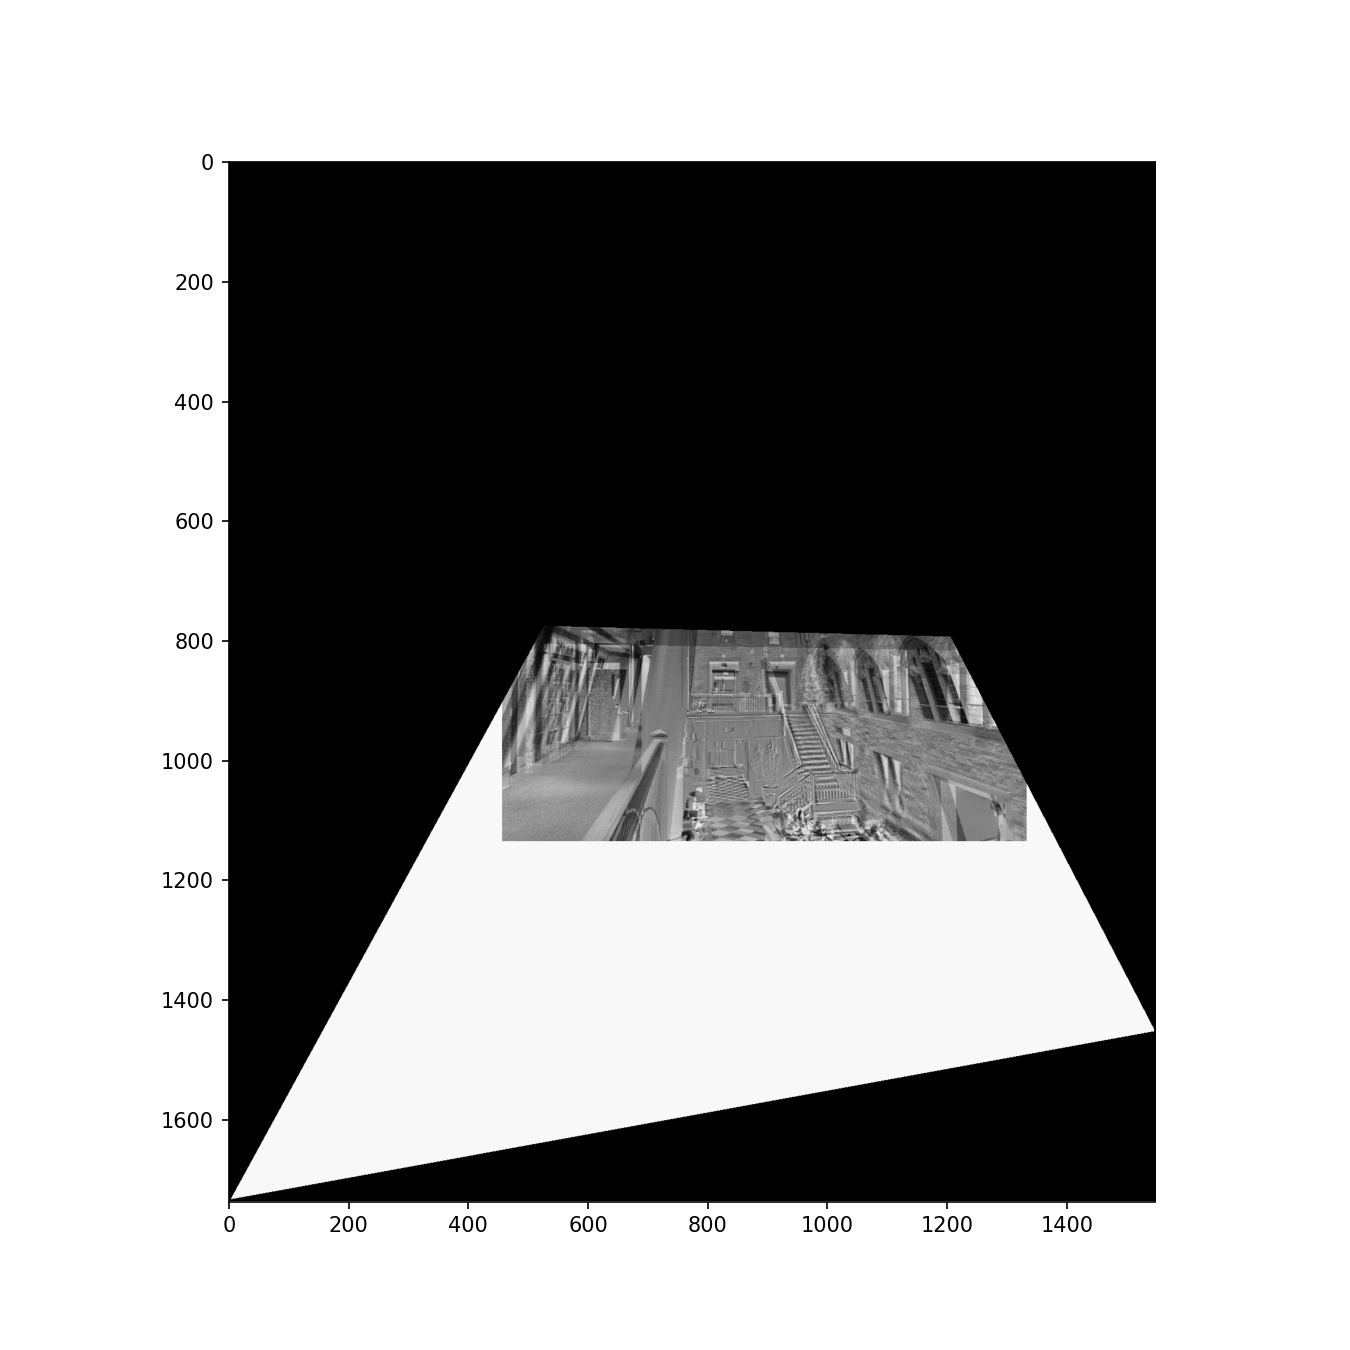

<IPython.core.display.Javascript object>


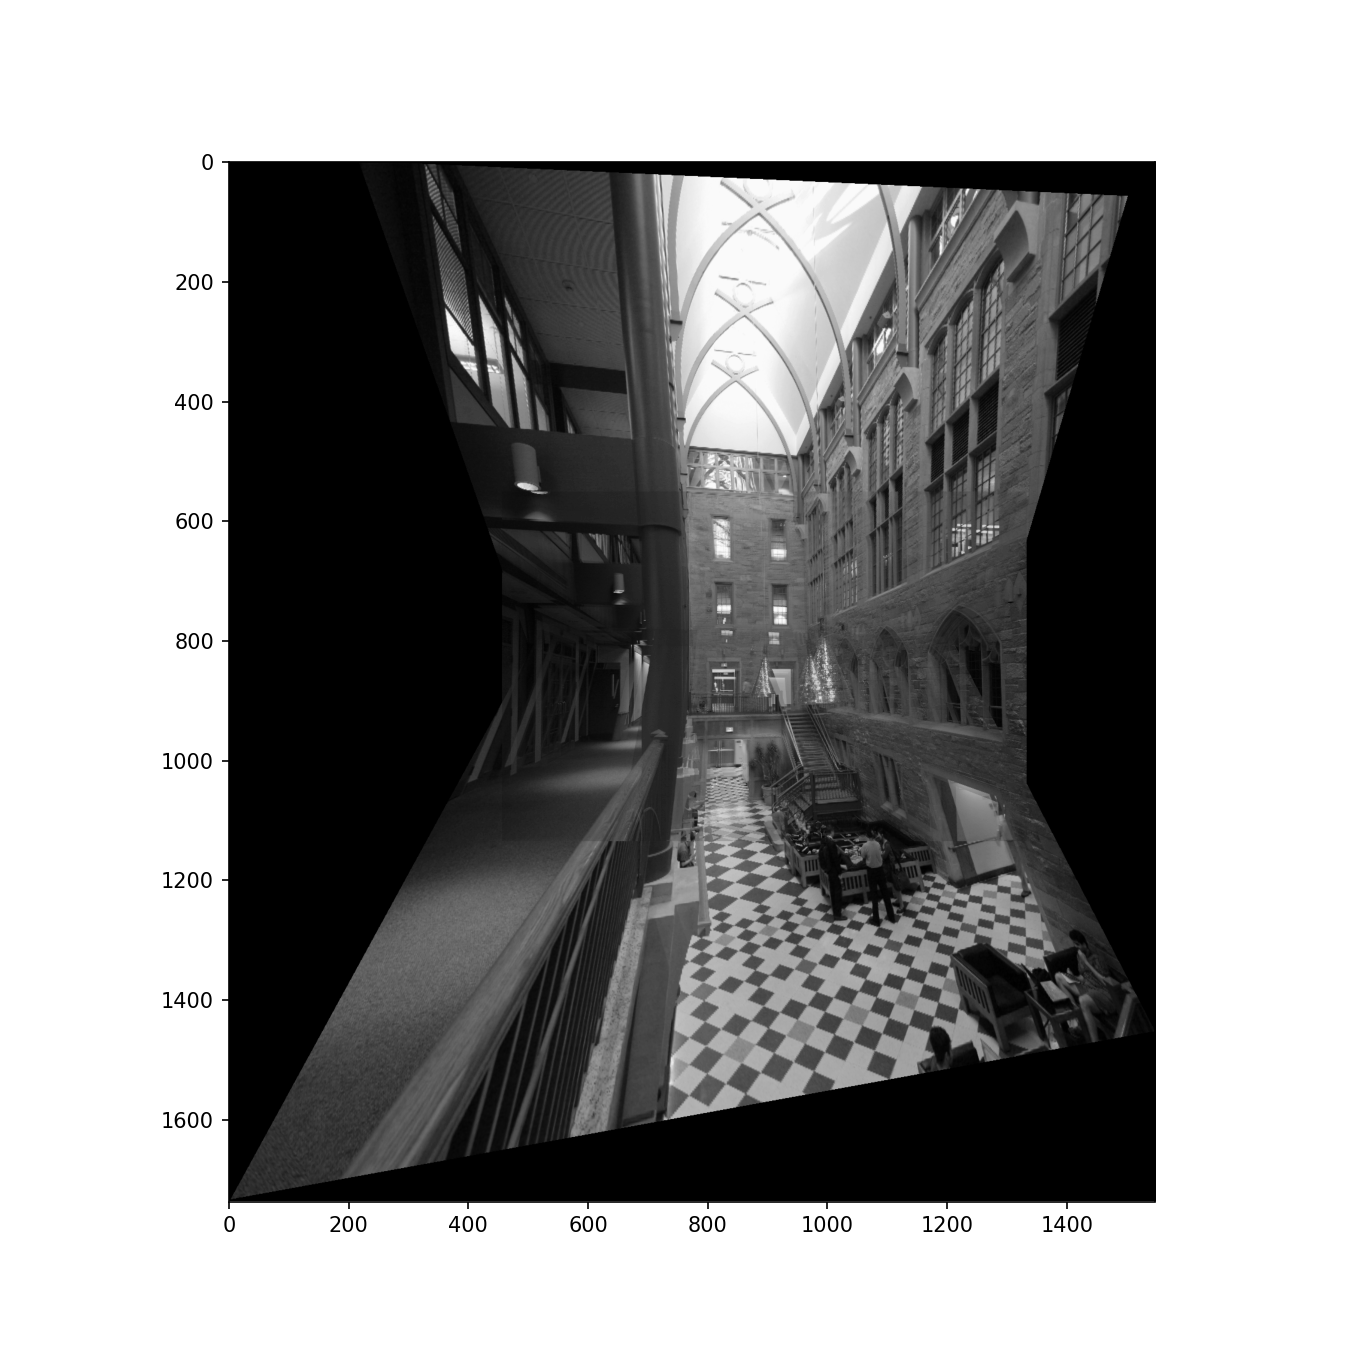

In [18]:
mosaic,alpha= blend_images(imgs_warped)
for i in range(len(imgs_warped)):
    fig = plt.figure()
    plt.imshow(alpha[i],cmap=plt.cm.gray)
    plt.show()
fig = plt.figure()
plt.imshow(mosaic,cmap=plt.cm.gray)
plt.show()